In [1]:
from math import sqrt
from sklearn.cross_validation import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import load_model
from matplotlib import pyplot
import smartOff

/home/bhushan/anaconda3/envs/SmartOff/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Start of helper functions

In [3]:
# Converting time series data to Supervised

def convertTimeSeriesToLSTM(inputData):
    DF = DataFrame(inputData)
    prepData = list()
    prepData.append(DF.shift(1))
    prepData.append(DF.shift(-1))
    lstmData = concat(prepData, axis= 1)
    # print(lstmData[:10])
    lstmData.dropna(inplace=True)
    # print(lstmData[:10])
    return lstmData

In [4]:
# End of helper functions

In [5]:
#datasetFull = read_csv('./data/house5/channel_5TV.dat_OnOFF_FULL.csv', sep=',') #names=['Index','Timestamp','Usage','Date','Year','Month','Day','Hour','Minute','Second'])
#datasetFull = datasetFull[:10000] #
#ndataset = datasetFull.drop(['Index', 'Timestamp', 'Date', 'Year'], axis = 1)
#dataset = ndataset[['Month', 'Day', 'Hour', 'Minute', 'Second', 'Usage']]
#values = dataset.values

In [6]:
file_read = read_csv('./data/house1/channel_13.dat', sep=' ', names=['Timestamp', 'Usage']) #names=['Index','Timestamp','Usage','Date','Year','Month','Day','Hour','Minute','Second'])
file_read['Timestamp'] = to_datetime(file_read['Timestamp'],unit='s')
file_read['Date'] = file_read['Timestamp'].dt.date
file_read['Year'] = file_read['Timestamp'].dt.year
file_read['Month'] = file_read['Timestamp'].dt.month
file_read['Day'] = file_read['Timestamp'].dt.day
file_read['Hour'] = file_read['Timestamp'].dt.hour
file_read['Minute'] = file_read['Timestamp'].dt.minute
file_read['Second'] = file_read['Timestamp'].dt.second

datasetFull = file_read
ndataset = datasetFull.drop(['Timestamp', 'Date', 'Year'], axis = 1)
dataset = ndataset[['Month', 'Day', 'Hour', 'Minute', 'Second', 'Usage']]


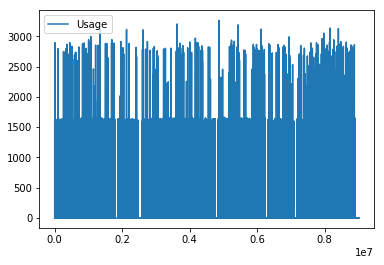

In [7]:
# graph for Usage
pyplot.plot(dataset['Usage'], label='Usage')
pyplot.legend()
pyplot.show()

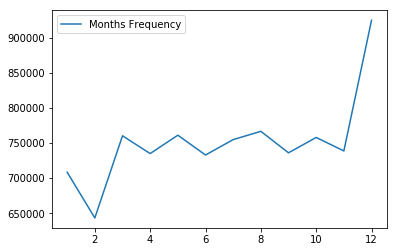

In [8]:
pyplot.plot(file_read['Month'].value_counts(sort=False), label='Months Frequency')
pyplot.legend()
pyplot.show()

In [9]:
#file_read['Usage'].value_counts()

In [9]:
#print(dataset[:5])
#scaler = MaxAbsScaler()
#scaled = scaler.fit_transform(dataset[:5])
#print(scaled)
#print(max(dataset['Month']), min(dataset['Month']), max(dataset['Usage']), min(dataset['Usage']))
maxUsage = max(dataset['Usage'])
#print(file_read['Usage'].value_counts())

In [10]:
# Normalizing features
from numpy import transpose
def normalizeTable(data, maxUsage = -1):
    data[0] = data[0] / 12  # Change to 12
    data[1] = data[1] / 31
    data[2] = data[2] / 24
    data[3] = data[3] / 60
    data[4] = data[4] / 60
    if maxUsage != -1:
        data[5] = data[5] / maxUsage
    return data

def normalizeData(values, maxUsage=-1):
    transposed = transpose(values)
    scaledT = normalizeTable(transposed, maxUsage)
    scaled = transpose(scaledT)
    return scaled

values = dataset.astype(float).values
maxUsage = max(dataset['Usage'])
scaled = normalizeData(values, maxUsage)


In [11]:
# Convert data to the format appropriate for LSTM 
lstmData = convertTimeSeriesToLSTM(scaled)

In [12]:
values = lstmData.values
print(values.shape)


(9018804, 12)


In [9]:
#print(values)

In [13]:
# Separate input and output data
values = lstmData.values
X = values[:,:5]
Y = values[:,5]

#print(Y)
# Splitting data into train, validation adn test set
X_Train, X_Temp, Y_Train, Y_Temp = train_test_split(X, Y, test_size=0.4)
X_Valid, X_Test, Y_Valid, Y_Test = train_test_split(X_Temp, Y_Temp, test_size =0.2)

# Reshape input to be 3D for LSTM input[samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Valid = X_Valid.reshape((X_Valid.shape[0], 1, X_Valid.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

In [11]:
#print (X_Train)
#print(Y_Train)

In [14]:
# network architecture
model = Sequential()
model.add(LSTM(100, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit
history = model.fit(X_Train, Y_Train, epochs=10, batch_size=10, validation_data=(X_Valid, Y_Valid), verbose=2, shuffle=False)

Train on 5411282 samples, validate on 2886017 samples
Epoch 1/10
1813s - loss: 0.0012 - val_loss: 0.0011
Epoch 2/10
1818s - loss: 0.0012 - val_loss: 0.0011
Epoch 3/10
1792s - loss: 0.0011 - val_loss: 0.0011
Epoch 4/10
1782s - loss: 0.0011 - val_loss: 0.0011
Epoch 5/10
1774s - loss: 0.0011 - val_loss: 0.0011
Epoch 6/10
1775s - loss: 0.0011 - val_loss: 0.0011
Epoch 7/10
1771s - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
1769s - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
1775s - loss: 0.0011 - val_loss: 0.0011
Epoch 10/10
1767s - loss: 0.0011 - val_loss: 0.0011


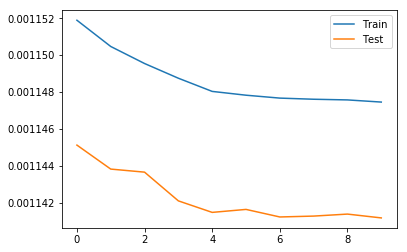

In [15]:
# plot history

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [16]:
print(Y_Test.shape, Y_Test.shape)

(721505,) (721505,)


In [17]:
# Predict for Test data
prediction = model.predict(X_Test)
Y_Test = Y_Test.reshape(Y_Test.shape[0],-1)

In [18]:
Diff = Y_Test - prediction

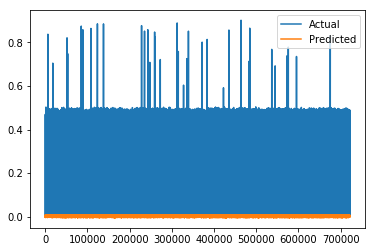

In [19]:
pyplot.plot(Y_Test, label='Actual')
pyplot.plot(prediction, label='Predicted')
pyplot.legend()
pyplot.show()

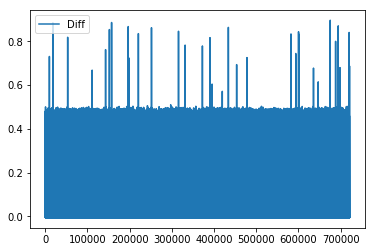

In [45]:
pyplot.plot(Diff, label='Diff')
pyplot.legend()
pyplot.show()

In [20]:
print(mean_squared_error(Y_Test, prediction))

0.00113715391988


In [20]:
#from numpy import concatenate
#print(prediction.shape, Y_Test.shape)
#compareAns = concatenate((prediction, Y_Test), axis=0)
#print(prediction[:10])
#print(Y_Test[:10])

In [28]:
# Save model on system
#model.save('savedModels/full_Microwave_2.h5')

In [16]:
#model = load_model('savedModels/full_Microwave.h5')

In [49]:
# EITHER FIND STANDBY USAGE VALUE FROM GIVEN TRAINING DATA
# OR USE EXISTING FROM 'metadata.json'

# standBy = dataset['Usage'].value_counts()
# print(standBy)

#from tinydb import TinyDB, Query
#db = TinyDB('metadata.json')
#metadata = Query()
#app = db.search(metadata.appliance == 'microwave')
#maxUsage = app[-1]['maxUsage']

2017-12-07 14:00:00


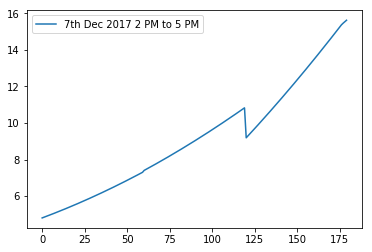

In [21]:
usage = smartOff.predictOnNext3Hours(model, "1512673200", maxUsage)
pyplot.plot(usage, label = "7th Dec 2017 2 PM to 5 PM")
pyplot.legend()
pyplot.show()

2017-12-07 07:30:00


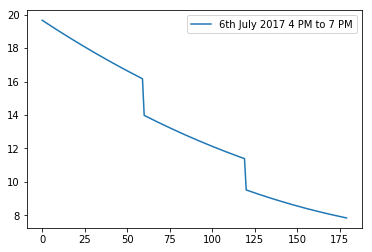

In [22]:
usage = smartOff.predictOnNext3Hours(model, "1512649800", maxUsage)
pyplot.plot(usage, label = "6th July 2017 4 PM to 7 PM")
pyplot.legend()
pyplot.show()

2018-01-10 05:00:00


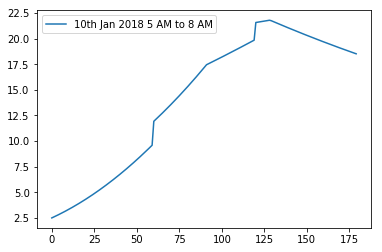

In [23]:
usage = smartOff.predictOnNext3Hours(model, "1515578400", maxUsage)
pyplot.plot(usage, label = "10th Jan 2018 5 AM to 8 AM")
pyplot.legend()
pyplot.show()

In [25]:
print(smartOff.predictForSingleTime(model, "1499382000", maxUsage, 'MICROWAVE'))

2017-07-06 19:00:00
False


In [27]:
#from tinydb import TinyDB, Query
#db = TinyDB('./metadata.json')
#db.insert({'appliance': 'microwave', 'maxUsage': max(dataset['Usage']) , 'threshold': 2})
